# Cohesive zone modeling of debonding and bulk fracture {far}`star`{far}`star`{far}`star`

```{admonition} Objectives
:class: objectives
This tutorial demonstrates  the formulation of a cohesive fracture model with `FEniCSx`. We adopt an *intrinsic* cohesive zone model (CZM) where cohesive elements are considered along all internal facets of the mesh. We will use for this purpose a Discontinuous Galerkin interpolation of the displacement field. The reader can also refer to {cite:p}`hansbo2015discontinuous` for a related work. Other key aspects include:
- Interface submeshes
- Interpolation of expressions on facets
- Fixed-point resolution strategy
$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\T}{^\text{T}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}
\renewcommand{\div}{\operatorname{div}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bt}{\boldsymbol{t}}
\newcommand{\jump}[1]{[\![#1]\!]}
\newcommand{\Gc}{G_{\text{c}}}
\newcommand{\sigc}{\sigma_{\text{c}}}$
```

The problem that we consider is a heterogeneous elastic plate consisting of a matrix phase and stiffer elastic inclusions. Weak cohesive elements along the interface are considered while the remaining part of the mesh facets also consists of cohesive elements with stronger mechanical properties. Damage caused by normal and tangential opening induces debonding at the interface and, later, fracture in the bulk matrix phase.

```{image} intrinsic_czm.gif
:align: center
:width: 600px
```

```{attention}
This tour requires version `0.9.0` of FEniCSx.
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./intrinsic_czm.py>`
* {Download}`Jupyter notebook<./intrinsic_czm.ipynb>`
```

## Cohesive zone modeling

### Traction-separation law

Cohesive zone models are interface elements characterized by a discontinuous displacement and are able to transmit forces through the interface. The link between the interface opening (displacement jump) $\jump{\bu}$ and the traction $\bT$ is given by the choice of a specific constitutive law, usually known as a *traction-separation* law.

Among the many models available in the literature, we choose here one of the simplest ones, namely an exponential traction separation law given by:

```{math}
:label: traction-separation

\bT(\jump{\bu}) = \dfrac{\Gc}{\delta_0^2}\exp(-\delta/\delta_0)\jump{\bu}
```

where $\Gc$ is the interface fracture energy and $\delta_0$ is another material parameter related to a critical opening. Finally,
$\delta$ is an effective opening displacement given by:

```{math}
:label: effective-opening

\delta(t) := \sqrt{\jump{u_n(t)}^2+\beta\jump{u_t(t)}^2}
```

and where $\beta$ is a coupling coefficient which enables to link the normal opening $\jump{u_n} = \jump{\bu}\cdot\bn$ and the tangential opening $\jump{u_t}=\jump{\bu}\cdot\bt$ with $\bn$ (resp. $\bt$) being the unit normal (resp. tangential vector) of the considered interface.

Alternatively, the traction-separation can be written as a function of a *damage variable* d given by:
```{math}
:label: damage

d = 1-\exp(-\delta/\delta_0)
```
yielding:

```{math}
:label: traction-separation-damage

\bT(\jump{\bu}, d) = \dfrac{\Gc}{\delta_0^2}(1-d)\jump{\bu}
```

The above law works as a nonlinear "spring" model with a secant stiffness given by $\dfrac{\Gc}{\delta_0^2}(1-d)$. In addition, we should also account for irreversibility of damage evolution. As a result, in an unloading phase (i.e. $\dot{\delta} < 0$), damage and thus stiffness should not decrease and the interface acts as a linear elastic spring. As a result, expression {eq}`damage` is modified to account for irreversibility as follows:

```{math}
:label: damage-irr

d(t) = \max_{t'\in[0;t]} 1-\exp(-\delta(t')/\delta_0)
```

In a loading phase for which $\dot{\delta}>0$, we have $\dot{d}>0$ and the interface element behaves as a nonlinear softening elastic spring. For a purely normal opening $(\jump{u_t}=0)$ in a loading phase, we have:
\begin{equation*}
T_n(\jump{u_n})=\dfrac{\Gc}{\delta_0^2}\exp(-\jump{u_n}/\delta_0)\jump{u_n}
\end{equation*}
which is maximum when $\jump{u_n}=\delta_0$ with a value $T_n(\delta_0) = \sigc = \dfrac{\Gc}{\delta_0}\exp(-1)$. $\delta_0$ therefore characterizes the critical opening for which the maximum strength $\sigc$ is reached. For $\jump{u_n}\gg \delta_0$, the stiffness tends to vanish and the cohesive element does no longer sustain any load. Finally, when integrating the traction-separation law for $\jump{u_n}$ from 0 to $+\infty$, we see that the total dissipated surface energy is:
\begin{equation*}
\text{Dissipation} = \int_0^{+\infty} T_n(\jump{u})d\jump{u} = \Gc
\end{equation*}
which is then the fracture energy spent when completely opening the interface.

The following script illustrates the pure normal opening behavior of the exponential cohesive law along a few loading/unloading cycles.

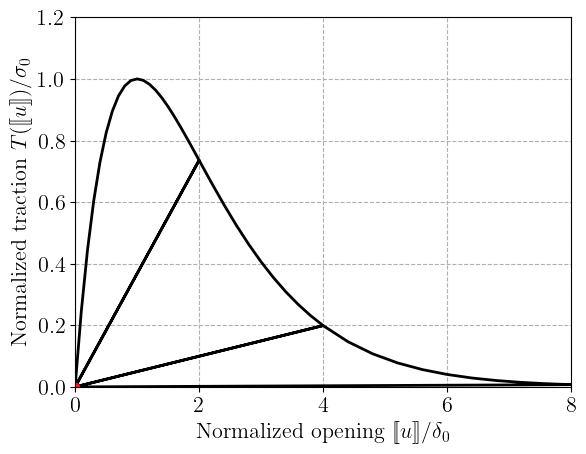

In [37]:
from IPython.display import clear_output, HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

delta_0 = 1.0
Gc = 1.0
sig_0 = Gc / delta_0 * np.exp(-1)
loading_cycles = [0, 2 * delta_0, 0, 4 * delta_0, 0, 8 * delta_0, 0]
loading_list = [np.array([0])]
for start, end in zip(loading_cycles[:-1], loading_cycles[1:]):
    loading_list.append(np.linspace(start, end, 21)[1:])
loading = np.concatenate(loading_list)

d = 0
T = np.zeros_like(loading)
for i, u in enumerate(loading):
    d = max(1 - np.exp(-abs(u) / delta_0), d)
    T[i] = Gc / delta_0**2 * (1 - d) * u / sig_0


fig = plt.figure()
ax = fig.gca()


def draw_frame(i):
    ax.clear()
    ax.set_xlim(min(loading_cycles), max(loading_cycles))
    ax.set_ylim(0, 1.2)
    ax.set_xlabel(r"Normalized opening $[\![u]\!]/\delta_0$")
    ax.set_ylabel(r"Normalized traction $T([\![u]\!])/\sigma_0$")
    lines = [
        ax.plot(loading[: i + 1], T[: i + 1], "-k")[0],
        ax.plot(loading[i], T[i], "oC3")[0],
    ]
    return lines


anim = animation.FuncAnimation(
    fig, draw_frame, frames=len(loading), interval=50, blit=True, repeat_delay=5000
)
plt.close()
HTML(anim.to_html5_video())

In [1]:
import pyvista
import gmsh
from mpi4py import MPI
import ufl
import basix.ufl
from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.fem.petsc import LinearProblem

```{warning}
Note that we do not distinguish here the tensile from the compressive regime. In practice, an asymmetric formulation should be considered, for instance with a high stiffness in compression to approximate a unilateral contact behavior.
```

### Variational formulation

Now we consider a domain $\Omega$ subject to imposed displacements on its Dirichlet boundary $\Dirichlet$ and under given body forces $\boldsymbol{f}$ In addition, the domain $\Omega$ contains a set of interfaces $\Gamma$ over which the displacement is discontinuous (jump $\jump{\bu}$) and for which the traction vector is given by the previous traction-separation law {eq}`traction-separation-damage`.

The weak form of equilibrium (virtual work principle) in presence of discontinuities reads:

$$
\int_\Omega \bsig:\nabla^\text{s} \bv \dOm + \int_{\Gamma}\bT\cdot\jump{\bv}\dS = \int_\Omega \boldsymbol{f}\cdot\bv \dOm \quad \forall \bv \in V_0
$$
where $\bT = \bsig\bn$ is the traction across $\Gamma$ of unit normal $\bn$ and $V_0$ is the test function space (kinematically admissible perturbations).

```{attention}
For the above expression to be consistent, the definition of the jump $\jump{\bu}$ should be:

$$
\jump{\bu} = \bu^\oplus - \bu^\ominus
$$
where $\bn$ is oriented from side $\ominus$ to side $\oplus$. Note that in UFL with `n = FacetNormal(domain)`, this definition of the normal vector $\bn$ therefore corresponds to the restriction on the $\ominus$ side i.e. `n("-")` since `n` points outwards a given cell.
```

Injecting the elastic constitutive relation and traction separation law, the resulting nonlinear problem is given by:
Find $\bu\in V$ such that:

```{math}
:label: czm-problem
\int_\Omega \bsig(\nabla^s\bu):\nabla^\text{s} \bv \dOm + \int_{\Gamma}\bT(\jump{\bu},d)\cdot\jump{\bv}\dS = \int_\Omega \boldsymbol{f}\cdot\bv \dOm \quad \forall \bv \in V_0
```
where $\bsig(\nabla^s \bu)$ is the linear elastic constitutive relation and where $d$ is given by {eq}`damage-irr` as a nonlinear function of $\jump{\bu}$.

### Fixed-point resolution strategy

The previous variational problem {eq}`czm-problem` is highly nonlinear. The Newton-Raphson method is not necessarily extremely robust in such softening situations, especially in the presence of unstable crack propagation phases. For this reason, we prefer here to resort to a fixed-point iteration scheme. For a given load step, we *iterate* between solving an elastic displacement problem with $d$ being fixed to a previously known value $d_i$, yielding the following linear problem:

Find $\bu^{(i+1)}\in V$ such that:

```{math}
\int_\Omega \bsig(\nabla^s\bu^{(i+1)}):\nabla^\text{s} \bv \dOm + \int_{\Gamma}\bT(\jump{\bu}^{(i+1)},d^{(i)})\cdot\jump{\bv}\dS = \int_\Omega \boldsymbol{f}\cdot\bv \dOm \quad \forall \bv \in V_0
```

The newly computed displacement $\bu^{(i+1)}$ is then used to update the value of the interfacial damage field from {eq}`damage-irr` as follows:

```{math}
\begin{align*}
d^{(i+1)} &= \max\{d_\text{prev};  1-\exp(-\delta^{(i+1)}/\delta_0)\}\\
\text{where } \delta^{(i+1)} &= \sqrt{\jump{u_n^{(i+1)}}^2+\beta\jump{u_t^{(i+1)}}^2}
\end{align*}
```
with $d_\text{prev}$ denotes the previous damage level reached before this time step in order to enforce an irreversible damage evolution.

These fixed point iterations are then stopped until $\|d^{(i+1)}-d^{(i)}\|\leq \epsilon$.

## Implementation

### Mesh and markers

We define a function to create the mesh and other utility functions.

In [2]:
def create_matrix_inclusion_mesh(L, W, R, hsize):
    comm = MPI.COMM_WORLD

    gmsh.initialize()
    gdim = 2
    model_rank = 0
    if comm.rank == model_rank:
        gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
        gmsh.model.add("Model")

        gmsh.model.occ.addRectangle(0.0, 0.0, 0.0, L, W, tag=1)
        gmsh.model.occ.addDisk(0.4, 0.0, 0.0, R, R, tag=2)
        gmsh.model.occ.addDisk(0.6, W, 0.0, R, R, tag=3)
        gmsh.model.occ.fragment([(gdim, 1)], [(gdim, 2), (gdim, 3)], removeObject=True)

        gmsh.model.occ.synchronize()

        gmsh.model.occ.remove([(gdim, 5), (gdim, 4)], recursive=True)

        gmsh.model.occ.synchronize()

        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

        gmsh.model.addPhysicalGroup(gdim, [1], 1, name="Matrix")
        gmsh.model.addPhysicalGroup(gdim, [2, 3], 2, name="Inclusions")

        gmsh.model.addPhysicalGroup(gdim - 1, [3], 1, name="left")
        gmsh.model.addPhysicalGroup(gdim - 1, [7], 2, name="right")
        gmsh.model.addPhysicalGroup(gdim - 1, [1, 5], 3, name="interface")
        gmsh.model.addPhysicalGroup(gdim - 1, [2, 9, 8, 4, 10, 6], 4, name="sides")
        gmsh.model.mesh.generate(gdim)

    partitioner = dolfinx.cpp.mesh.create_cell_partitioner(
        dolfinx.mesh.GhostMode.shared_facet
    )
    domain, cells, facets = dolfinx.io.gmshio.model_to_mesh(
        gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim, partitioner=partitioner
    )
    gmsh.finalize()
    return (domain, cells, facets)


def create_piecewise_constant_field(
    domain, cell_markers, property_dict, name=None, default_value=0
):
    """Create a piecewise constant field with different values per subdomain.

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    cell_markers : MeshTag
        cell marker MeshTag
    property_dict : dict
        A dictionary mapping region tags to physical values {tag: value}

    Returns
    -------
    A DG-0 function
    """
    V0 = fem.functionspace(domain, ("DG", 0))
    k = fem.Function(V0, name=name)
    k.x.array[:] = default_value
    for tag, value in property_dict.items():
        cells = cell_markers.find(tag)
        k.x.array[cells] = np.full_like(cells, value, dtype=np.float64)
    return k


def plot_mesh(domain, marker, **kwargs):
    plotter = pyvista.Plotter()
    ugrid = pyvista.UnstructuredGrid(
        *dolfinx.plot.vtk_mesh(domain, marker.dim, marker.indices)
    )
    ugrid.cell_data["Marker"] = marker.values
    plotter.add_mesh(ugrid, show_edges=True, **kwargs)
    plotter.show_axes()
    plotter.view_xy()
    plotter.show()

We first create the mesh and define the different tags for identifying physical domains and interfaces.

In [3]:
length = 1.0
width = 0.5
radius = 0.25
hsize = 0.02
domain, cell_marker, facet_marker = create_matrix_inclusion_mesh(
    length, width, radius, hsize
)
INNER_FACET_TAG = 0  # tag of inner facets except interface
MATRIX_TAG = 1  # tag of matrix phase
INCL_TAG = 2  # tag of inclusion phase
INT_TAG = 3  # tag of interface

tdim = domain.topology.dim
fdim = tdim - 1

annotations = {
    MATRIX_TAG: "Matrix",
    INCL_TAG: "Inclusion",
}
plot_mesh(domain, cell_marker, annotations=annotations, cmap="plasma_r")

We recreate a facet `MeshTag` object from the one produced by `gmsh` to mark inner facets as `INNER_FACET_TAG` and plot it.

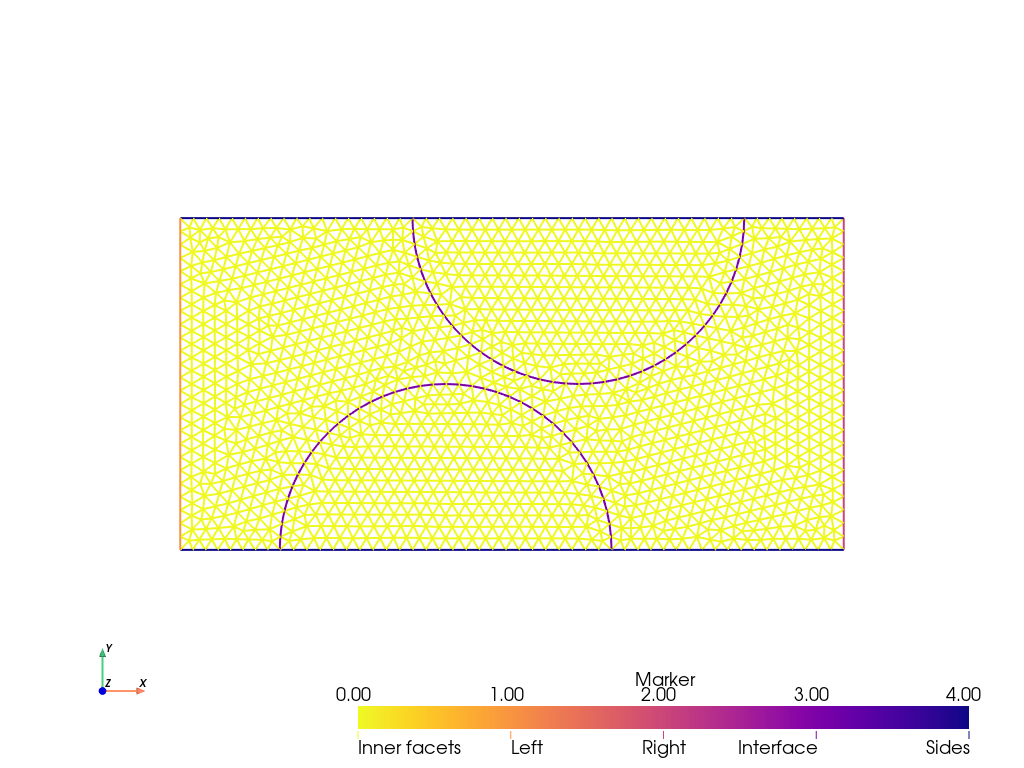

In [5]:
domain.topology.create_connectivity(fdim, tdim)
facet_map = domain.topology.index_map(fdim)
num_facets_local = facet_map.size_local + facet_map.num_ghosts
facet_values = np.full(num_facets_local, INNER_FACET_TAG, dtype=np.int32)
facet_values[facet_marker.indices] = facet_marker.values
facets = dolfinx.mesh.meshtags(
    domain, fdim, np.arange(num_facets_local, dtype=np.int32), facet_values
)
annotations = {
    1: "Left",
    2: "Right",
    INT_TAG: "Interface",
    INNER_FACET_TAG: "Inner facets",
    4: "Sides",
}
plot_mesh(domain, facets, annotations=annotations, line_width=2, cmap="plasma_r")

### Submesh creation

Here, we use the new functionalities offered by version `0.9.0` to create **submeshes** using `dolfinx.mesh.create_submesh`. The submesh will be of co-dimension[^codim] 1 and consists of facets in $\Gamma$ i.e. facets of the interface $\Gamma_\text{int}$ and of inner facets in $\Gamma_\text{bulk}$.

[^codim]: *Co-dimension* is a geometric concept which refers to the geometric dimension of a subset relative to a larger set. A co-dimension `codim` means that the subset is of dimension `dim-codim` where `dim` refers to the dimension of the original set. In the present context, facets are of co-dimension 1 with respect to the original mesh consisting of cells i.e. in 2D cells are of dimension 2 and facets of dimension 1, in 3D cells are of dimension 3 and facets of dimension 2.

In [6]:
internal_facets = np.concatenate([facets.find(m) for m in [INNER_FACET_TAG, INT_TAG]])
interface_mesh, interfaces_cell_map, interfaces_vertex_map, _ = (
    dolfinx.mesh.create_submesh(domain, fdim, internal_facets)
)

We must also recreate a `MeshTag` based on the new `interface_mesh` to correctly identify regions of the submesh.

In [7]:
num_sub_facets = len(interfaces_cell_map)
interfaces_facet_tags = dolfinx.mesh.meshtags(
    interface_mesh,
    fdim,
    np.arange(num_sub_facets, dtype=np.int32),
    facets.values[interfaces_cell_map],
)

Finally, an important concept when dealing with integration of forms involving coefficients defined on a different mesh than the integration domain is that of an *entity map*. An entity map is a dictionary which links a mesh with a mapping relating entities in the integration domain mesh to the submesh, see also https://jsdokken.com/FEniCS-workshop/src/multiphysics/submeshes.html#integration-with-function-from-parent-and-sub-mesh.

In [8]:
facet_imap = domain.topology.index_map(facets.dim)
num_facets = facet_imap.size_local + facet_imap.num_ghosts
domain_to_interfaces = np.full(num_facets, INNER_FACET_TAG)
domain_to_interfaces[interfaces_cell_map] = np.arange(len(interfaces_cell_map))
entity_maps = {interface_mesh: domain_to_interfaces}

We now define the different integration measures. Note that we must choose a specific domain with which to associate the integration measure. We will use the full mesh `domain`, as it will be more convenient when dealing with multiple geometric dimensions. We check that the sum $|\Gamma_\text{int}|+|\Gamma_\text{bulk}|$ is equal to the total interface measure $|\Gamma|$ measured by integrating a cell measure over the submesh.

In [9]:
dx = ufl.Measure("dx", domain=domain)
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)
dS = ufl.Measure("dS", domain=domain, subdomain_data=facets)
dx_int = ufl.Measure("dx", domain=interface_mesh)
Gamma_int = fem.assemble_scalar(fem.form(1 * dS(INT_TAG)))
Gamma_bulk = fem.assemble_scalar(fem.form(1 * dS(INNER_FACET_TAG)))
Gamma = fem.assemble_scalar(fem.form(1 * dx_int))
print(f"Total interface area = {Gamma_int:.3f}")
print(f"Total inner facets area = {Gamma_bulk:.3f}")
print(f"Total interface measure = {Gamma:.3f} vs {Gamma_int+Gamma_bulk:.3f}")

Total interface area = 1.570
Total inner facets area = 86.602
Total interface measure = 88.172 vs 88.172


### Weak form formulation

We first define linear elastic material properties by creating two fields for the Young modulus $E$ and Poisson ratio $\nu$, taking piecewise constant values in the matrix and inclusion phases. We refer to [](/tips/piecewise_constant_field/piecewise_constant_field.md) for more details. UFL functions for the strain and stress expressions are then defined.

In [10]:
E = create_piecewise_constant_field(
    domain, cell_marker, {MATRIX_TAG: 3.09e3, INCL_TAG: 10e3}
)
nu = create_piecewise_constant_field(
    domain, cell_marker, {MATRIX_TAG: 0.25, INCL_TAG: 0.4}
)
mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))


def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(tdim) + 2.0 * mu * epsilon(v)

We define the two material parameters representing the fracture energy $\Gc$ and the critical stress $\sigc$. Both fields are piecewise constant functions (`"DG"-0`) defined on the interface mesh. Both parameters have smaller values on the interface, while facets in the bulk have stronger mechanical properties. We then define various functions such as {eq}`effective-opening`, {eq}`damage` and {eq}`traction-separation-damage` which will serve for expressing the cohesive law.

In [11]:
Gc = create_piecewise_constant_field(
    interface_mesh, interfaces_facet_tags, {INT_TAG: 0.5}, name="Gc", default_value=1.0
)
sig_max = create_piecewise_constant_field(
    interface_mesh,
    interfaces_facet_tags,
    {INT_TAG: 50.0},
    name="sigmax",
    default_value=400.0,
)
delta_0 = Gc / sig_max / ufl.exp(1)
beta = fem.Constant(domain, 2.0)


def normal_opening(v, n):
    return ufl.dot(v, n)


def tangential_opening(v, n):
    return v - normal_opening(v, n) * n


def effective_opening(v, n):
    return ufl.sqrt(normal_opening(v, n) ** 2 + beta**2 * tangential_opening(v, n) ** 2)


def T(opening, d):
    K_int = ufl.avg(Gc / delta_0**2) * (1 - d)
    return K_int * opening

Two function spaces are now defined. `V` refers to the displacement function space using a **Discontinuous Galerkin** (`"DG"`) of degree 1.

We will also need to compute quantities which live only on the facets of the mesh e.g. the internal variables of the cohesive law (the damage `d` in the present case). The space `V_int` consists of a `"DG"` interpolation of degree 1 (piecewise affine on the facet and discontinuous at the vertices). This choice is made to simplify the visualization of facet fields. To enforce irreversibility of damage evolution, `d_prev` will store the value of interfacial damage at the previous converged increment. Finally, to test convergence of the damage field during the fixed-point iteration scheme, `d_old` will store the value of interfacial damage of the previous iteration.

Note that an alternative for V_int is to use a quadrature space on the facet mesh using the space `Q` defined later. However, functions on `Q` can then only be visualized as point clouds, see https://scientificcomputing.github.io/scifem/examples/xdmf_point_cloud.html.

In [12]:
V = fem.functionspace(domain, ("DG", 1, (tdim,)))
u = fem.Function(V, name="Displacement")
v = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

V_int = fem.functionspace(interface_mesh, ("DG", 1))
d = fem.Function(V_int, name="Interfacial_damage")
d_prev = fem.Function(V_int, name="Previous_interfacial_damage")
d_old = fem.Function(V_int, name="Interfacial_damage_old")

The variational forms are now defined. The weak form contains the current value of damage `d` defined as a function on the facet mesh. This function being fixed, the resulting problem is therefore linear. The corresponding bilinear and linear (zero in the present example) forms are compiled using the previously defined entity map which allows to integrate forms containing functions defined on a submesh.

The interface contribution `a_interface` to the bilinear form contains jump terms defined on all internal facets (bulk + interface) via the measure `dS`. Since we use an inner surface measure, all quantities must be restricted onto a facet. Although `d` lives on the facet mesh, we still need to restrict it in some way. We use here `ufl.avg`, although `"+"` or `"-"` would have also worked.

In [13]:
a_bulk = ufl.inner(sigma(du), epsilon(v)) * dx
a_interface = ufl.dot(T(ufl.jump(du), ufl.avg(d)), ufl.jump(v)) * dS
a = a_bulk + a_interface

f = fem.Constant(domain, (0.0, 0.0))
Fext = ufl.dot(f, v) * dx

a_compiled = fem.form(a, entity_maps=entity_maps)
Fext_compiled = fem.form(Fext, entity_maps=entity_maps)

(facet:expressions:interpolation)=
### Facet expressions interpolation

In the load stepping process, the fixed-point procedure will iteratively update the damage field `d` with a new value computed from the current displacement estimate. To do so, we must compute the nonlinear expression {eq}`damage` at the interpolation points corresponding to the degrees of freedom of the `V_int` function space, namely the two vertices of a facet. To do so, we will build a linear form such that its assembled vector exactly corresponds to a vector of interpolated values using a custom quadrature trick.

Suppose that we want to evaluate an expression `e` at certain points on facets. Assuming that $Q$ is a quadrature function space defined on facets and $x_g$, $\omega_g$ are $n$ quadrature integration points and weights defined on the reference element, the facet quadrature rule can be expressed as follows:

$$
\int_{F} \widehat{e} q \dS = \sum_{g=1}^{n} |F|\omega_g \widehat{e}(x_g)q(x_g) \quad \forall q\in Q
$$
where $F$ is a facet, $|F|$ its area measure, $\widehat{e}$ is a generic expression and $q$ is a test function in $Q$.
Generalizing this quadrature over a set of facets, the resulting assembled vector will therefore contains the values $|F|\omega_g \widehat{e}(x_g)$ at the corresponding dofs. As a result, if we choose $\widehat{e} = e/|F|$ and $\omega_g=1$, the resulting assembled vector will exactly contains the wanted values $e(x_g)$.

This strategy is implemented below. The damage expression `d_expr` to interpolate is first defined. Note that it is defined as the maximum between expression {eq}`damage` and `d_prev` to ensure irreversibility. A custom `basix` quadrature element using unitary weights and interpolation points of `V_int` as quadrature points is defined on the interface mesh. The corresponding custom integration measure is also defined. Finally, `facet_interp` contains the compiled form discussed previously.

In [14]:
n = ufl.FacetNormal(domain)
delta = effective_opening(ufl.jump(u), n("-"))
d_expr = ufl.max_value(ufl.avg(d_prev), 1 - ufl.exp(-delta / ufl.avg(delta_0)))

q_p = V_int.element.interpolation_points()
weights = np.full(q_p.shape[0], 1.0, dtype=dolfinx.default_scalar_type)
q_el = basix.ufl.quadrature_element(
    interface_mesh.basix_cell(), scheme="custom", points=q_p, weights=weights
)
Q = fem.functionspace(interface_mesh, q_el)
q_ = ufl.TestFunction(Q)
dS_custom = ufl.Measure(
    "dS",
    domain=domain,
    metadata={
        "quadrature_scheme": "custom",
        "quadrature_points": q_p,
        "quadrature_weights": weights,
    },
    subdomain_data=facets,
)

facet_interp = fem.form(
    1 / ufl.FacetArea(domain) * d_expr * ufl.avg(q_) * dS_custom,
    entity_maps=entity_maps,
)

### Dirichlet boundary conditions

Here, we define the Dirichlet boundary conditions consisting of fixed displacement on the left part and and an imposed displacement $(t, 0)$ on the right boundary.Note that since we use DG discretization of the displacement field,
DG dofs do not live on the facets but are associated with cell interior. As a result, they cannot be found using `locate_dofs_topological` and the facet marker. We must use a geometrical approach to locating the dofs instead.

Note that an alternative could have been to employ a weak Nitsche imposition of the Dirichlet BCs which is very similar to a cohesive traction law at the boundary.

Finally, the imposed displacement constant `Uimp` is initialized with unitary values. This will serve to define a unitary virtual displacement field `v_reac` to be used for measuring the reaction force on the boundary in a consistent manner. We refer to [](/tips/computing_reactions/computing_reactions.md) for more details.

In [15]:
Uimp = fem.Constant(domain, (1.0, 0.0))
left_dofs = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0.0))
right_dofs = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], length))
bcs = [
    fem.dirichletbc(np.zeros((tdim,)), left_dofs, V),
    fem.dirichletbc(Uimp, right_dofs, V),
]

v_reac = fem.Function(V)
fem.set_bc(v_reac.x.array, bcs)
virtual_work_form = fem.form(
    ufl.action(ufl.action(a, u) - Fext, v_reac), entity_maps=entity_maps
)

The linear problem associated with resolution of displacement at fixed damage is now defined outside the load-stepping loop.

In [16]:
problem = LinearProblem(
    a_compiled,
    Fext_compiled,
    u=u,
    bcs=bcs,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
)

We will monitor the evolution of total damage over the structure by computing a normalized (or average) value of damage, separating its contribution from the physical interface $\Gamma_\text{int}$ from the internal facets in the bulk matrix $\Gamma_\text{bulk}$.

In [17]:
interface_damage = fem.form(ufl.avg(d) * dS(INT_TAG), entity_maps=entity_maps)
bulk_damage = fem.form(
    ufl.avg(d) * dS(INNER_FACET_TAG),
    entity_maps=entity_maps,
)

### Load-stepping

The load stepping loop is now started with progressively applied imposed displacement. For each load step, the inner fixed-point iteration loop is performed to first compute the new displacement and then update the value of damage by evaluating its expression on the different facets from assembling the `facet_interp` form. Convergence is checked by measuring the $L^2$ difference between two consecutive values of the damage field.

At the end of each time step, the total resulting force on the right boundary is computed as well as normalized values of the total damage, distinguishing the interfacial from the bulk contribution. Finally, the `d_prev` variable is updated with new values to account for damage irreversibility.

In [19]:
Nincr = 60
loading = np.linspace(0, 0.06, Nincr + 1)

Niter_max = 200
tol = 1e-4
damage_results = [[0.0, 0.0]]
Force = [0.0]
iterations = [0]
out_file = io.VTKFile(MPI.COMM_WORLD, "results/czm.pvd", "a")
for i, t in enumerate(loading[1:]):
    if MPI.COMM_WORLD.rank == 0:
        print(f"Load step {i+1}/{len(loading)-1}")
    Uimp.value[0] = t
    nRes = 1.0
    j = 0
    while j < Niter_max:
        # displacement problem resolution
        problem.solve()
        # interpolation of damage on facets
        d.x.array[:] = fem.assemble_vector(facet_interp).array
        # normalized residual for convergence check
        nRes = (
            np.sqrt((fem.assemble_scalar(fem.form((d - d_old) ** 2 * dx_int)))) / Gamma
        )
        d_old.x.array[:] = d.x.array[:]
        j += 1
        print(f"    Iteration {j:2d} | Residual: {nRes}")
        if nRes < tol:
            break
    else:
        raise ValueError(
            "Fixed-point solver did not converge in less than {} iterations".format(
                Niter_max
            )
        )
    iterations.append(j)
    d_prev.x.array[:] = d.x.array[:]

    Force.append(fem.assemble_scalar(virtual_work_form))
    damage_results.append(
        [fem.assemble_scalar(interface_damage), fem.assemble_scalar(bulk_damage)]
    )

    out_file.write_function(u, i)
    out_file.write_function(d, i)
    clear_output(wait=True)

out_file.close()

Load step 60/60
    Iteration  1 | Residual: 5.084060128822264e-11


### Force-displacement and damage evolution

As showcased in the initial GIF animation, the matrix/inclusion interface first starts to open almost elastically, then a sudden drop in the force-displacement curve corresponds to the unstable debonding of a large portion of both interfaces. The remaining load-carrying part of the structure then continues to stretch until a sudden final fracture of the central region.

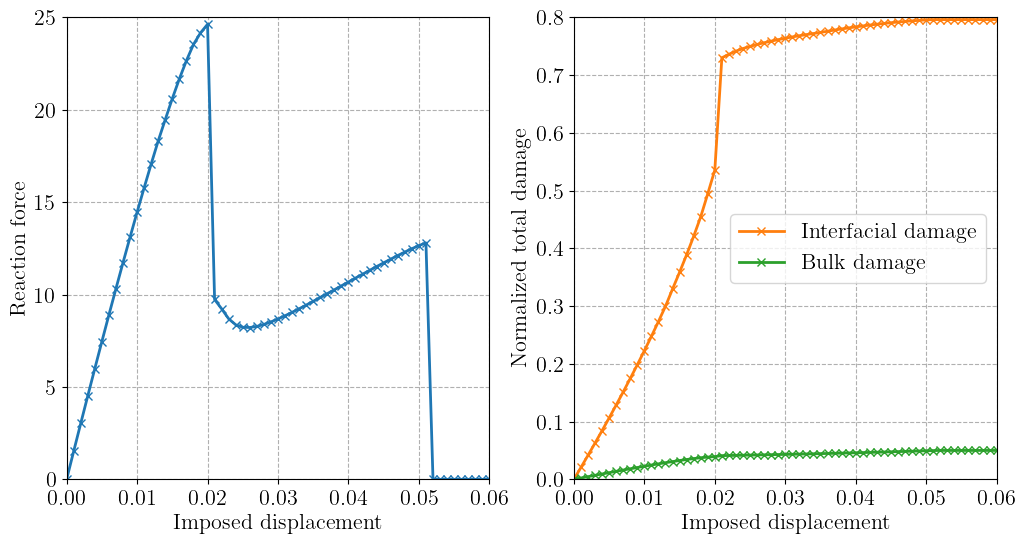

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loading, Force, "-x")
plt.xlabel("Imposed displacement")
plt.ylabel("Reaction force")
plt.subplot(1, 2, 2)
plt.plot(
    loading,
    np.asarray(damage_results)[:, 0] / Gamma_int,
    "-xC1",
    label="Interfacial damage",
)
plt.plot(
    loading, np.asarray(damage_results)[:, 1] / Gamma_bulk, "-xC2", label="Bulk damage"
)
plt.legend()
plt.xlabel("Imposed displacement")
plt.ylabel("Normalized total damage")
plt.show()

## References

```{bibliography}
:filter: docname in docnames
```